In [2]:
import os
import json
import re
from tqdm import tqdm
import pickle
import itertools
import networkx as nx
from matplotlib import pyplot as plt
import networkx
import glob
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import numpy as np
import pickle
from glob import glob
from os.path import join

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/onovitskaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/onovitskaya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def delete_non_letters(words):
    new_words = []
    for word in words:
        new_word = "".join(c for c in word if c.isalpha())
        if new_word != '':
            new_words.append(new_word)
    return new_words

def delete_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english') and word not in stopwords.words('russian'):
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def normalize(text, tokenized=False, del_stopwords=False):
    if not tokenized:
        text = nltk.word_tokenize(text)
    
    text = delete_non_letters(text)
    if del_stopwords:
        text = delete_stopwords(text)
        
    text = to_lowercase(text)
    
    text = [word for word in text if len(word) > 1]
    return text

In [10]:
df_texts = pd.read_csv('tj_texts_upd.csv').rename({'0':'preprocessed'}, axis=1).dropna(subset=['preprocessed'])

In [12]:
df_texts

,doc_id,text,preprocessed
0,2,Казачьим обществом «ИРБИС» в Петербурге была ...,Казачьим обществом «ИРБИС» в Петербурге была ...
1,3,Последняя версия мессенджера Whats App на And...,Последняя версия мессенджера Whats App на And...
2,4,Подросток Марсель Фернандес Фильо из Бразилии...,Подросток Марсель Фернандес Фильо из Бразилии...
3,5,Чо как дела ребят,Чо как дела ребят
4,6,Лихачев няшка. Ваши мнения?,Лихачев няшка. Ваши мнения?
...,...,...,...
298688,449995,,
298689,449996,\#tg\_arkhlikbez,\#tg\_arkhlikbez
298690,449997,Инстателочка на связи! Раз инста в ахуе загруж...,Инстателочка на связи! Раз инста в ахуе загруж...
298692,449999,,


In [13]:
texts = list(df_texts.preprocessed)

In [14]:
df_texts

,doc_id,text,preprocessed
0,2,Казачьим обществом «ИРБИС» в Петербурге была ...,Казачьим обществом «ИРБИС» в Петербурге была ...
1,3,Последняя версия мессенджера Whats App на And...,Последняя версия мессенджера Whats App на And...
2,4,Подросток Марсель Фернандес Фильо из Бразилии...,Подросток Марсель Фернандес Фильо из Бразилии...
3,5,Чо как дела ребят,Чо как дела ребят
4,6,Лихачев няшка. Ваши мнения?,Лихачев няшка. Ваши мнения?
...,...,...,...
298688,449995,,
298689,449996,\#tg\_arkhlikbez,\#tg\_arkhlikbez
298690,449997,Инстателочка на связи! Раз инста в ахуе загруж...,Инстателочка на связи! Раз инста в ахуе загруж...
298692,449999,,


In [15]:
texts_lens = []
for text in tqdm(texts):
    tok_text = nltk.word_tokenize(text)
    tok_text = normalize(tok_text, tokenized=True)
    texts_lens.append(len(tok_text))

100%|██████████████████████████████████| 296981/296981 [13:01<00:00, 380.02it/s]


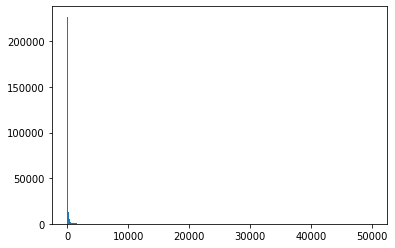

In [16]:
plt.hist(texts_lens, bins=[i * 100 for i in range(int(50000/100))])
plt.show()

In [23]:
texts_lens = np.array(texts_lens)
small_texts_mask = texts_lens < 30

In [24]:
df_texts[~small_texts_mask]

,doc_id,text,preprocessed
1,3,Последняя версия мессенджера Whats App на And...,Последняя версия мессенджера Whats App на And...
2,4,Подросток Марсель Фернандес Фильо из Бразилии...,Подросток Марсель Фернандес Фильо из Бразилии...
7,12,"Приставка сделана в виде небольшой флешки, ко...","Приставка сделана в виде небольшой флешки, ко..."
10,15,Популярный ресурс про Apple и тренды перезапу...,Популярный ресурс про Apple и тренды перезапу...
11,16,"Житель Ижевска, который разместил у себя на с...","Житель Ижевска, который разместил у себя на с..."
...,...,...,...
298662,449964,Встречаются 5ый член и Кнорозов. Кнорозов расс...,Встречаются 5ый член и Кнорозов. Кнорозов расс...
298668,449971,Кнорозов пишет объявление: “Админское собрание...,Кнорозов пишет объявление: “Админское собрание...
298677,449983,искусственный интеллект в конечном счете приде...,искусственный интеллект в конечном счете приде...
298684,449990,"Какие сервисы затронуло, предварительные причи...","Какие сервисы затронуло, предварительные причи..."


In [25]:
df_texts[~small_texts_mask].to_csv('tj_texts_upd_large.csv', index=False)

# Stopwords

In [6]:
stopwords_path = join('/stopwords')
stopwords_template = join(stopwords_path, '*.txt')
stopwords_files = glob(stopwords_template)
extra_stopwords = set()
for name in stopwords_files:
    with open(name, 'r') as f:
        words = f.readlines()
        words = [word.strip() for word in words]
        extra_stopwords.update(set(words))

#Also putting there nltk stopwords
stopwords = set()
stopwords.update(set(nltk_stopwords.words('english')))
stopwords.update(set(nltk_stopwords.words('russian')))
stopwords.update(extra_stopwords)

#some euristically added stopwords
custom_stopwords = set(['http', 'https', 'ru', 'com', 'vk',
                         'привет', 'здравствуйте', 'например', 'репост'])

#stopwords from final LDA tuning
#comment this piece it if you haven`t got them.
#final_stopwords_path = join(stopwords_path, 'final_extra_stopwords.pkl')
#with open(final_stopwords_path, 'rb') as f:
#    stopwords_from_top = pickle.load(f)
#stopwords.update(set(stopwords_from_top))

stopwords.update(custom_stopwords)
stopwords = list(stopwords)
print('Total numver of stopwords:', len(stopwords))

#serializing all-merged stopwords set
with open('./stopwords/stopwords.pkl', 'wb') as f:
    pickle.dump(stopwords, f)

Total numver of stopwords: 339
